In [2]:
# from Batman.batman_monsoon import make_lightcurve, make_batman
# from Convolve.convolve import tbconvolve, read_tess, read_batman, open_tess_fits, convolve
# from Science.generalized_chisquared import make_table

import tessbatman as tb
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Configure Batman Parameter File
rmin = -1  # radius (log scale)
rmax = -1
rstep = 1
wmin = -3.9  # width param (log scale)
wmax = -2.5
wstep = 30
suffix = "_test"  # suffix to append to all files
params = ['batmanCurves{}.csv'.format(suffix), 
          'batmanParams{}.csv'.format(suffix),
          *map(str, (rmin, rmax, rstep, wmin, wmax, wstep))]
tb.make_batman_config(rmin, rmax, rstep, wmin, wmax, wstep, suffix)
# suffix = '_test'
# param_names = ['LIGHTCURVE_TABLE','PARAMETERS_TABLE','LOG_R_MIN','LOG_R_MAX','NUM_R_STEP',
#          'LOG_W_MIN','LOG_W_MAX','NUM_W_STEP']
# params = ['batmanCurves{}.csv'.format(suffix), 'batmanParams{}.csv'.format(suffix),
#           '-1', '-1', '1', '-3.9', '-2.5', '30']
# paramfile = 'param{}.txt'.format(suffix)
# with open(paramfile, 'w') as f:
#     f.write('# Batman Parameter File\n')
#     for i in range(len(params)):
#         f.write(' = '.join([param_names[i], params[i]]) + '\n')

In [3]:
# Make batman curves
paramfile = "/common/contrib/classroom/ast520/tess_batman/code/param_test.txt"
pb = "/common/contrib/classroom/ast520/tess_batman/code/"
bparams, bcurves = tb.make_batman(paramfile, pb, norm=True, write=True)

Generating curves


/scratch/classroom/ast520/tess_batman/code/tessbatman.py:116: RuntimeWarning: invalid value encountered in arccos
  lim = np.arccos((1 + r)/(a))/(2 * np.pi) * 360
/scratch/classroom/ast520/tess_batman/code/tessbatman.py:154: RuntimeWarning: invalid value encountered in true_divide
  c = (c-cmin)/(cmax-cmin) # scale to [0,1]


Batman curve0 failed
Batman curve1 failed
Batman curve2 failed
Batman curve3 failed
Batman curve4 failed
Batman curve5 failed
Batman curve6 failed
Batman curve7 failed
Batman curve8 failed
Batman curve9 failed
Generated 290/300 curves in 0.6944215297698975 s
Writing files
Wrote files in 0.6121506690979004 s


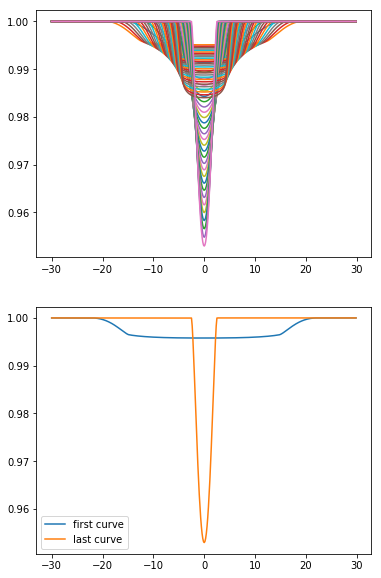

In [4]:
# A bunch of curves
f, axs = plt.subplots(2, figsize=(6,10))
for curveID in bcurves.colnames[10::5]:
    axs[0].plot(bcurves['times'], bcurves[curveID], label=curveID)
axs[1].plot(bcurves['times'], bcurves[bcurves.colnames[1]], label='first curve')
axs[1].plot(bcurves['times'], bcurves[bcurves.colnames[-1]], label='last curve')
plt.legend()

In [7]:
# pt = "/home/ctaiudovicic/projects/tess_batman/data/TESS/"
pt = "/common/contrib/classroom/ast520/tess_batman/sampleData/"
tstart = 2
tend = tstart+1
tess_names = tb.read_tess(pt, pt+"sample_Sector0", tstart, tend)
times, curve_names, batmanCurves = tb.read_batman(pt+"batmanCurves_test.csv")
tess_time, tess_flux = tb.open_tess_fits(tess_names[0], norm=True)
curves, times, convs = tb.convolve(tess_time, tess_flux, batmanCurves, curve_names, num_keep=len(curve_names))

# candidates for tstart to tend
candidates = tb.tbconvolve(pt, pb, suffix, 0, tstart, tend, pb, num_keep = -1, norm_tess=True, write=False)
# do all candidates and write to file
_ = tb.tbconvolve(pt, pb, suffix, 0, 0, 9, pb, num_keep = -1, norm_tess=True, write=True)

plt.plot(tess_time, tess_flux, 'bx')

Reading TESS from /common/contrib/classroom/ast520/tess_batman/sampleData/sample_Sector0, s:2, e:3...
Reading batmanCurves from /common/contrib/classroom/ast520/tess_batman/sampleData/batmanCurves_test.csv...
Starting convolutions...
Convolved 300 curves in 0.748 s
===START TCONVOLVE===
Reading TESS from sample_Sector0, s:2, e:3...
Found 1 TESS files to process
Reading batmanCurves from /common/contrib/classroom/ast520/tess_batman/code/batmanCurves_test...


FileNotFoundError: [Errno 2] No such file or directory: '/common/contrib/classroom/ast520/tess_batman/code/batmanCurves_test'

61 76


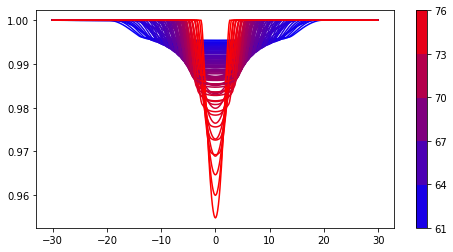

In [6]:
import matplotlib.colors as c
start = 10
step = 71

fig = plt.figure(figsize=(8, 4))
cm = c.LinearSegmentedColormap.from_list('mycolors',['blue','red'])
# make colorbar
cmin = int(100*np.nanmin(candidates['correlation']))
cmax = int(100*np.nanmax(candidates['correlation']))
print(cmin, cmax)
if (cmax-cmin > 5):
    step = (cmax-cmin)//5
    if step < 1:
        step = 1
    Z = [[0,0],[0,0]]
    levels = range(cmin,cmax+step,step)
    CS3 = plt.contourf(Z, levels, cmap=cm)
    plt.clf()

    for i, curve in enumerate(bcurves.colnames[start::step]):#, len(candidates)):
        row = candidates[candidates['curveID'] == curve]
        r = (100*float(row['correlation'])-cmin)/(cmax-cmin)
        if r > 1:
            r = 1
        plt.plot(bcurves['times'], bcurves[curve], color=(r, 0, 1-r))
    plt.colorbar(CS3)

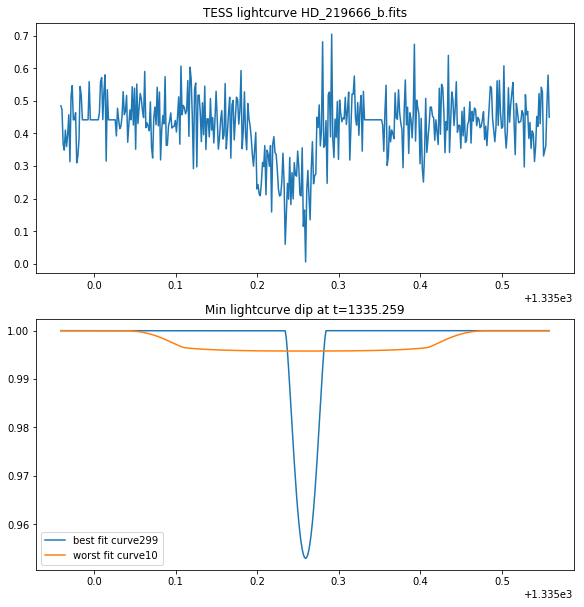

In [7]:
best = candidates[np.argmax(candidates['correlation'])]
worst = candidates[np.argmin(candidates['correlation'])]
tess_curve = tess_names[0].split("/")[-1]

# Search for dip
ind = np.argmin(tess_flux[:15700])
# ind=6311
size = len(bcurves['times'])//2
s = ind-size
e = ind+size
mid = (e+s)//2

# Plot lightcurve, best and worst fits
f, axs = plt.subplots(2, figsize=(8,8))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.5)

# testcurve = 'curve59'
# axs[0].plot(tess_time[s:e], bcurves[testcurve], label=testcurve)

axs[0].plot(tess_time[s:e], tess_flux[s:e])

axs[1].plot(tess_time[s:e], bcurves[best['curveID']], label='best fit '+best['curveID'])
axs[1].plot(tess_time[s:e], bcurves[worst['curveID']], label='worst fit '+worst['curveID'])


axs[0].set_title("TESS lightcurve {}".format(tess_curve))
axs[1].set_title("Min lightcurve dip at t={:.3f}".format(tess_time[ind]))

axs[1].legend()

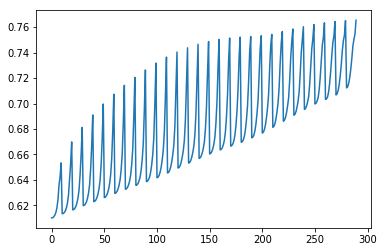

In [8]:
# max convolutions of each curve
plt.plot(convs)

curve10 1347.3552833404792 0.6101873906319727
curve60 1347.32195011349 0.6261611577294044
curve110 1347.3275056511675 0.6417567302334123
curve160 1347.3441722651332 0.6603905779714133
curve210 1347.326116766515 0.6768421449305478
curve260 1347.32195011349 0.6996703787753749
curve299 1335.2496901983852 0.7653937129226922


Text(0.5, 33.0, 'time (days)')

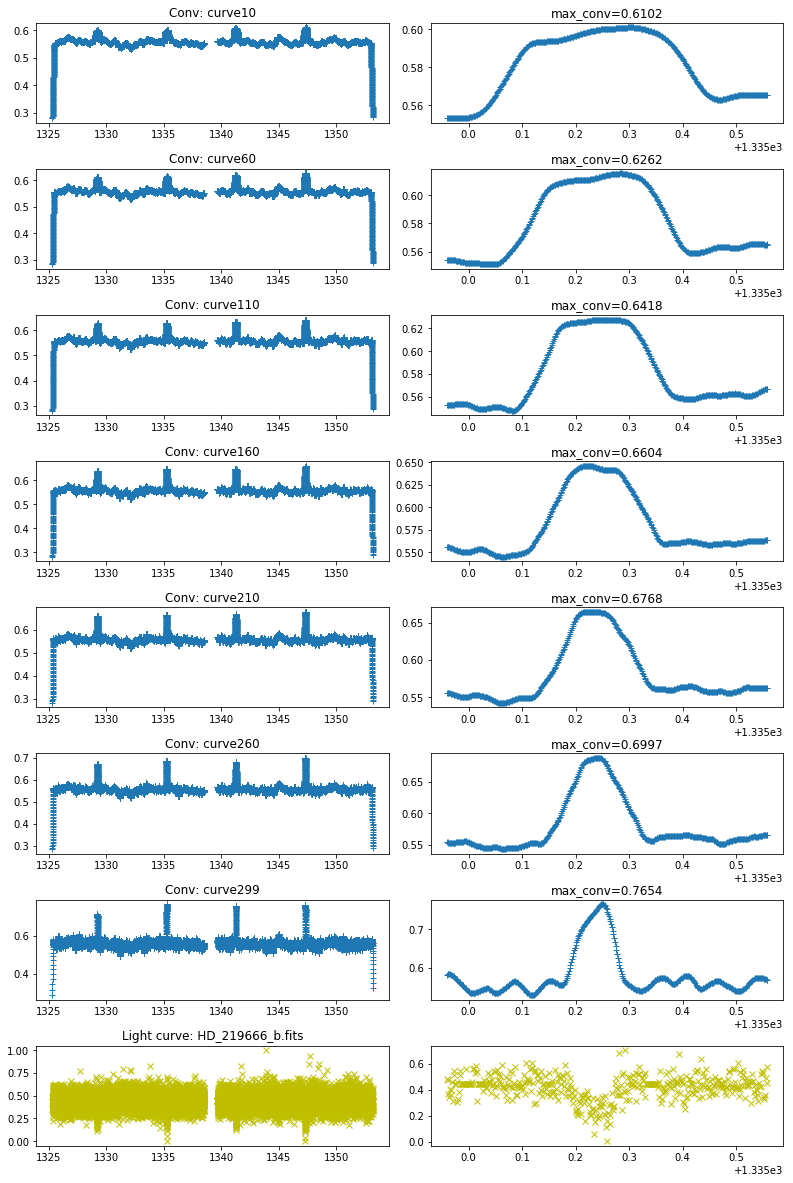

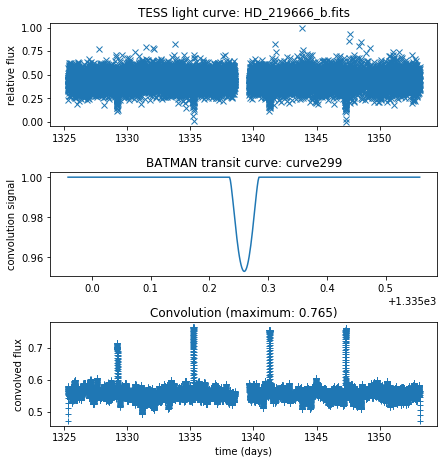

In [15]:
# manual convolve and plots
from scipy.signal import fftconvolve
plot = True


cnames = np.append(curve_names[0::50], best['curveID'])
nplots = len(cnames)+1
fig, axs = plt.subplots(nplots,2, figsize=(11, nplots*2))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.5)
for i, curvename in enumerate(cnames):
    batman_curve = batmanCurves[curvename]
    conv = np.abs(fftconvolve(1-tess_flux, (1-batman_curve), 'same'))
    ind_max = np.argmax(conv)
    conv_max = conv[ind_max]
    
    print(curvename, tess_time[ind_max], conv_max)
    axs[i,0].plot(tess_time, conv, '+')
    axs[i,1].plot(tess_time[s:e], conv[s:e], '+')
    axs[i,0].set_title("Conv: {}".format(curvename))
    axs[i,1].set_title("max_conv={:.4f}".format(conv_max))

     
axs[-1,0].plot(tess_time, tess_flux, 'yx')
axs[-1,1].plot(tess_time[s:e], tess_flux[s:e], 'yx')
axs[-1,0].set_title("Light curve: {}".format(tess_names[0].split("/")[-1]))


fig2,axs2 = plt.subplots(3, figsize=(6,6))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.5)

axs2[0].set_title("TESS light curve: {}".format(tess_names[0].split("/")[-1]))
axs2[0].set_ylabel("relative flux")
axs2[0].plot(tess_time, tess_flux, 'x')
axs2[1].set_title("BATMAN transit curve: {}".format(best['curveID']))
axs2[1].set_ylabel("convolution signal")
axs2[1].plot(tess_time[s:e], bcurves[best['curveID']], label=best['curveID'])
axs2[2].set_title("Convolution (maximum: {:.3f})".format(conv_max))
axs2[2].set_ylabel("convolved flux")
axs2[2].plot(tess_time[conv>0.45], conv[conv>0.45], '+')
axs2[2].set_xlabel("time (days)")

In [ ]:
params_file = "batmanParams_test.csv"
candidates_file = "candidates_sector0_s0_e8.csv"
make_table(pt, params_file, candidates_file)

In [ ]:
import pandas as pd
chisq_file = "chisquared_values.csv"
chisq = pd.read_csv(chisq_file)

In [ ]:
chisq.sort_values('reducedChiSq').head(20)